## Задача 
## «Проектное исследование на основе открытых данных в области биомедицины»

### Цель

Применение как классических методов машинного обучения, так и глубокого обучения для достижения наилучших результатов в предсказании наличия или отсутствия одного из 42 заболеваний на основе анализа 132 симптомов. Набор данных состоит двух датасетов: набор для обучения **training.csv** и набор для тестирования модели **testing.csv**.

### Описание данных:

Каждый файл CSV содержит 133 столбца, из которых 132 — это симптомы различных заболеваний, а последний столбец — прогноз заболевания (представлена 41 нозология). 


Проблема классификации данных с наличием нескольких классов может решаться путем предварительной обработки данных (укрупнения классов, например). Если это невозможно из-за характера данных, тогда применяются модели машинного обучения с расширениями для обработки мультитаргетов (skilearn.multiclass) или модели, способные обрабатывать мультитаргеты напрямую(XGBClassifaier).

Необходимо обучить модели на обучающих данных с учетом наличия мультитаргета и протестировать на тестовых данных.

### Признаки:



## Библиотеки

In [70]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Библиотеки для машинного обучения
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (    # Импорт конкретных функций оценки из подмодуля metrics
    accuracy_score,              # Импорт функции для оценки точности (accuracy) модели, т.е. доли правильно предсказанных примеров
    balanced_accuracy_score,     # Импорт функции для оценки сбалансированной точности, учитывающей классовую неоднородность
    precision_score,             # Импорт функции для вычисления точности (precision)
    recall_score,                # Импорт функции для вычисления полноты (recall)
    confusion_matrix,            # Импорт функции для создания матрицы ошибок (confusion matrix):TN, TP, FN, FP
    multilabel_confusion_matrix, # Импорт функции для создания матрицы ошибок для случаев с многомерной классификацией
    f1_score,                    # Импорт функции для вычисления F1-меры
    roc_auc_score,               # Импорт функции для вычисления AUC-ROC (площадь под кривой приемлемости и ошибок)
    roc_curve,                   # Импорт функции для вычисления координат для построения ROC-кривой
    average_precision_score,     # Импорт функции для вычисления средней точности (average precision)
    precision_recall_curve       # Импорт функции для вычисления и визуализации кривой "точность-полнота" (precision-recall curve)
)

# Модели
from xgboost import XGBClassifier
from sklearn.svm import SVC # Импорт классификатора на основе метода опорных векторов (SVM)
from sklearn.multiclass import OneVsRestClassifier


# Для глубокой нейронной сети
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [71]:
def check_missing_values(df):
    '''процент пропущенных значений'''
    missing_info = df.isnull().sum()
    total_missing = missing_info.sum()

    if total_missing == 0:
        return {"message": "No missing values found."}
    else:
        missing_percentage = (missing_info[missing_info > 0] / len(df)) * 100
        return {
            "total_missing": total_missing,
            "missing_columns": missing_percentage.to_dict()
        }

In [72]:
def check_duplicates(df):
    '''наличие дубликатов'''
    duplicate_rows = df.duplicated().sum()

    if duplicate_rows == 0:
        return {"message": "No duplicate rows found."}
    else:
        return {"total_duplicates": duplicate_rows}

In [73]:
def create_binary_indicators(df, target_column):
    '''бинарное кодирование каждого диагноза для корреляционного анализа.
    0 - нет диагноза, 1 - есть'''
    diagnoses = df[target_column].unique()
    
    for diagnosis in diagnoses:
        df[diagnosis] = (df[target_column] == diagnosis).astype(int)
    return df, diagnoses

In [74]:
def calculate_top_correlations(df, diagnoses):
    '''определение топ 5 корреляций признаков с бинарными диагнозами'''
    numeric_data = df.select_dtypes(include='number') # корреляция только для количественных признаков
    
    correlations = {}
    for diagnosis in diagnoses:
        corr_values = numeric_data.corr()[diagnosis].abs().sort_values(ascending=False)
        top_features = corr_values[1:6]  # исключая диагноз
        correlations[diagnosis] = top_features
    return correlations

In [75]:
def plot_heatmaps(df, correlations, num_diagnoses=5):
    '''корреляционные матрицы для наиболее коррелирующих признаков для 5 диагнозов'''
    selected_diagnoses = list(correlations.keys())[:num_diagnoses]

    for diagnosis in selected_diagnoses:
        top_features = correlations[diagnosis]
        plt.figure(figsize=(10, 6))
        sns.heatmap(df[top_features.index].corr(), annot=True, cmap='coolwarm')
        plt.title(f"Корреляционная матрица наиболее коррелирующих признаков для {diagnosis}")
        plt.show()

In [76]:
def plot_bar_chart_of_most_correlated(correlations):
    '''bar chat наиболее коррелирующего признака для каждого диагноза'''
    diagnoses = []
    top_features = []
    for diagnosis, features in correlations.items():
        if not features.empty:
            diagnoses.append(diagnosis)
            top_features.append(features.index[0])  # наиболее коррелирующие признаки
 
    plt.figure(figsize=(12, len(diagnoses) * 0.4)) # ширина плота 12, высота плота вмещает все диагнозы с запасом 0.4
    bar_lengths = [1] * len(diagnoses)  # длина баров 1 для всего количества диагнозов
    plt.barh(diagnoses, bar_lengths, color='lightblue')
    plt.xlabel("Наиболее коррелирующие признаки")
    plt.ylabel("Диагноз")
    plt.title("Наиболее коррелирующие признаки для каждого диагноза")

    # Наименование признаков
    for i, feature in enumerate(top_features):
        plt.text(0.5, i, feature, va='center', ha='right') # 0.5 размещение по центру бара

    plt.show()

In [77]:
def category_mapping(df, col):
    '''кодировка категориальных признаков'''
    for column in col:
        unique_values = df[column].unique()
        mapping = {value: index for index, value in enumerate(unique_values)}
        df[column] = df[column].map(mapping)
    return df

In [78]:
def data_prepare_learning(df,df_target):
    '''подготовка данных к обучению'''
    # Конвертация категориальных переменных в dummy переменные
    X_dummies = pd.get_dummies(df, drop_first=True)  # drop_first=True для уменьшения мультиколлинеарности 
    
    # Разделение на train и test датасеты
    X_train, X_test, y_train, y_test = train_test_split(X_dummies, df_target, test_size=0.2, random_state=42)
    
    # Инициализация StandardScaler
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    # Выделение числовых данных для стандартизации
    numeric_columns = X_train.select_dtypes(include=np.number).columns
    
    # Стандартизация числовых данных
    X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])
    
    return X_train_scaled, X_test_scaled, y_train,y_test

## Загрузка и исследование датасета

In [79]:
train = pd.read_csv('Training.CSV')
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 134 entries, itching to Unnamed: 133
dtypes: float64(1), int64(132), object(1)
memory usage: 5.0+ MB


In [80]:
train.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [81]:
train.shape

(4920, 134)

In [82]:
train['prognosis'].nunique()

41

In [83]:
train.nunique()

itching                  2
skin_rash                2
nodal_skin_eruptions     2
continuous_sneezing      2
shivering                2
                        ..
blister                  2
red_sore_around_nose     2
yellow_crust_ooze        2
prognosis               41
Unnamed: 133             0
Length: 134, dtype: int64

In [84]:
train['prognosis'].value_counts(normalize=False, ascending=False)

prognosis
Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B                                120
All

In [85]:
check_missing_values(train)

{'total_missing': 4920, 'missing_columns': {'Unnamed: 133': 100.0}}

In [86]:
check_duplicates(train)

{'total_duplicates': 4616}

In [87]:
train_eda = train.copy() # создание копии датасета для корреляционного анализа

In [88]:
train_eda, diagnoses = create_binary_indicators(train_eda, 'prognosis') # бинарное кодирование диагнозов

In [89]:
correlations = calculate_top_correlations(train_eda, diagnoses) # определение наиболее коррелирующих признаков с диагнозами

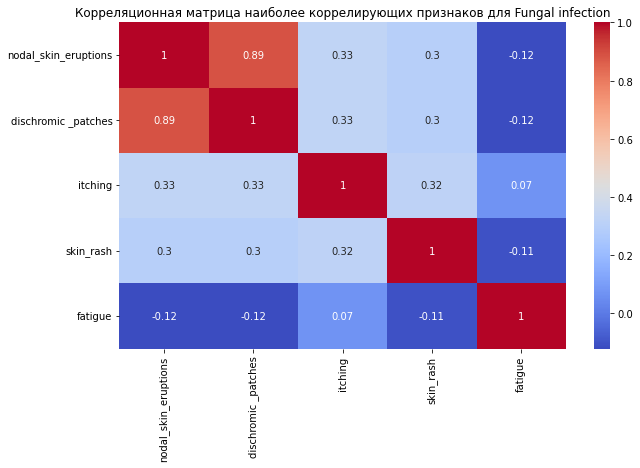

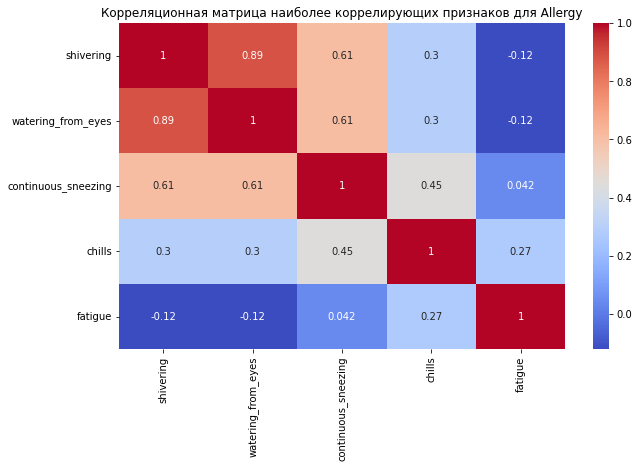

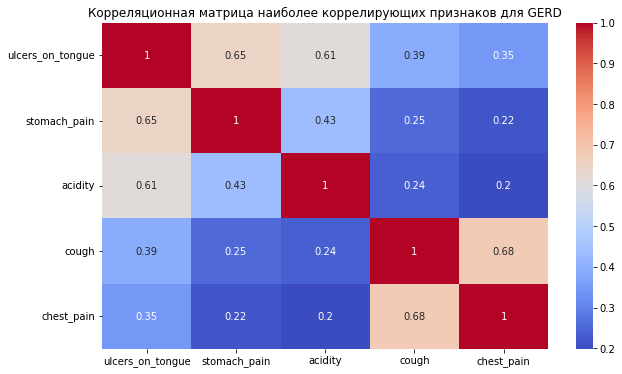

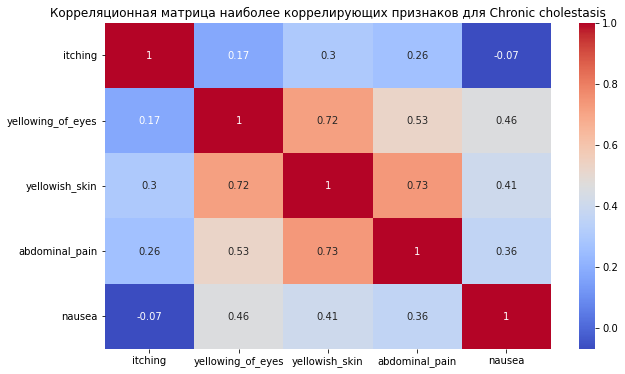

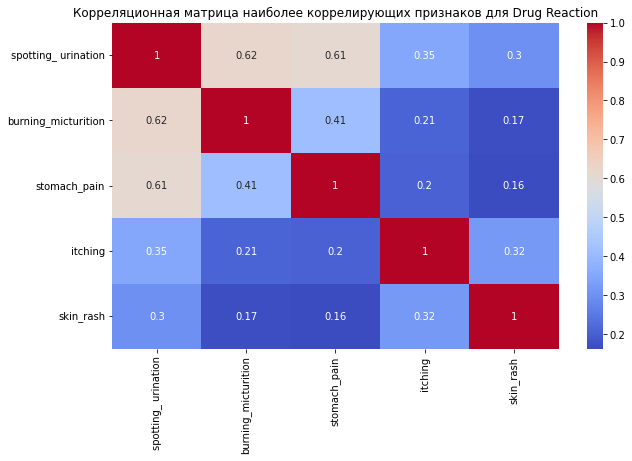

In [90]:
plot_heatmaps(train_eda, correlations) # корреляционные матрицы для 5 диагнозов

Визуализация c помощью heatmap помогает определить, какие симптомы чаще встречаются вместе, что может быть полезно для понимания закономерностей в определении заболевания.

Например, heatmap показывает, что сочетание появления подкожно-узловой сыпи (nodal_skin_eruptions) и слабо - пигментных пятен (dischromic_patches) указывает на наличие грибковых инфекций.
Такие симптомы, как зуд (itching) и кожные высыпания (skin_rash), имеют умеренную корреляцию друг с другом и другими кожными проявлениями, слабость (fatique) не является специфическим признаком для данной нозологии.

Следующая визуализация помогает установить взаимосвязь симптомов на прогноз аллергии. Сильная положительная корреляция между симптомами дрожь (shivering) (неврологическая симптоматика) и слезотечение (watering_from_eyes), а также  корреляция средней силы, выявленная между выше указанными симптомами и заложенностью носа (continuous_sneezing) указывает на частое сочетанное появление при сильных аллергических реакциях.

Озноб (chills) и слабость (fatigue) являются неспецифичными признаками для данной нозологической группы, поэтому не имеют прогностической значимости.

Следующая визуализация представляет собой матрицу корреляции для симптомов, встречающихся при гастроэзофагеальной рефлюксной болезни (GERD). Выявление значимой положительной корреляционной связи между такими клиническими проявлениями, как язвы на языке (ulcers_on_tongue), боль в желудке (stomach_pain) и повышенная кислотность (acidity) свидетельствуют о частом сочетании данных симптомов при развитии GERD.
Слабая положительная корреляция симптомов кашля (cough) и боли за грудиной (chest_pain) с другими специфическими признаками свидетельствует о низкой прогностической значимости данных клинических проявлений для постановки диагноза GERD.

Матрица корреляции была построена для признаков, появляющихся при развитии хронического холестаза (Chronic Cholestasis). Умеренная и сильно выраженная корреляция выявлена между такими симптомами, как иктеричность склер (yellowing_of_eyes), желтуха (yellowish_skin), боль в брюшной полости (abdominal_pain), что может свидетельствовать об их частом сочетании при развитии данной нозологии. Слабая и очень слабая положительная корреляционная связь выявлена между выше названными симптомами, тошнотой (nausea) и кожным зудом (itching), что говорит об их недостаточной специфичности для прогноза данного заболевания.

Последняя heatmap иллюстрирует матрицу корреляции для нескольких симптомов, обычно связанных с лекарственными реакциями (Drug Reactions). Корреляционная связь средней силы между симптомами кровянистые выделения при мочеиспускании (spotting_urination) и жжение при мочеиспускании (burning_micturition) указывает на достаточную совместную частоту встречаемости данных признаков. Слабая корреляция выявлена между выше указанными симптомами и болью в животе (stomach_pain), что свидетельствует о недостаточной связи между указанными признаками. Корреляционные связи между симптомами кожный зуд (itching) и кожные высыпания (skin_rash) достаточно слабы, чтобы иметь прогностическую значимость для выявления лекарственных реакций. 

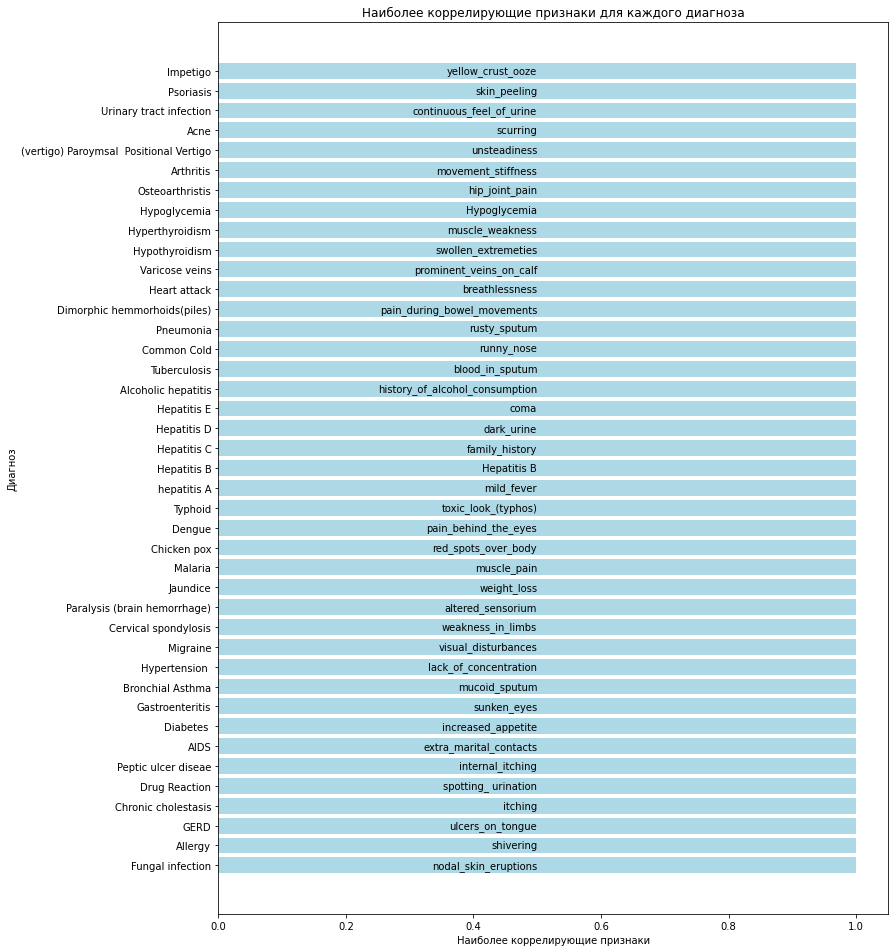

In [91]:
plot_bar_chart_of_most_correlated(correlations) # наиболее коррелирующий признак для каждого диагноза соответственно

На этой диаграмме выделен основной симптом для каждого заболевания, что может помочь в быстрой идентификации или диагностике на основе выраженных клинических признаков.

В диаграмме перечислены различные медицинские заболевания, такие как импетиго, псориаз, инфекция мочевыводящих путей, акне, артрит, пневмония, туберкулез, варианты гепатита (A, B, C, D, E), малярия, желтуха, лихорадка денге и другие.

Наиболее коррелирующие симптомы: каждый диагноз связан с симптомом, который показывает самую высокую корреляцию. 

Импетиго — струп (корка) желтого цвета.\
Псориаз — шелушение кожи.\
Инфекция мочевыводящих путей — постоянные позывы к мочеиспусканию.\
Акне - угревая сыпь и образование рубцов.\
Артрит — скованность движений.\
Остеоартрит - боль в тазобедренном суставе.\
Гипогликемия - снижение уровня глюкозы в крови.\
Гипертиреоз - мышечная слабость.\
Гипотереоз - отеки конечностей.\
Варикозное расширение вен - расширение вен нижних клонечностей (голеней).\
Сердечный приступ - одышка.\
Геморрой - боль во время акта дефекации.\
Пневмония - кровянистая мокрота.\
Простуда - насморк.\
Туберкулез - кровохарканье.\
Алкогольный гепатит - в анамнезе употребление алкоголя.\
Гепатит E - кома.\
Гепатит D - темная моча.\
Гепатит С - наследственность в анамнезе.\
Гепатит B - гепатит B.\
Гепатит A - субфебрильная лихорадка.\
Тиф - тифозный статус (резкая заторможенность, нарушение сознания, бред, галлюцинации).\
Лихорадка Денге - боль в глазах.\
Ветряная оспа - сыпь (красные пятна) на всем теле.\
Малярия - боль в мышцах.\
Желтуха — потеря веса.\
Геморрагический инсульт (паралич) - нарушение чувствительности.\
Шейный остеохондроз - слабость в конечностях.\
Мигрень - нарушение зрения.\
Артериальная гипертония - нарушение концентрации внимания.\
Бронхиальная астма - слизистая мокрота.\
Гастроэнтерит -  запавшие глаза.\
Диабет - повышенный аппетит.\
СПИД - внебрачные контакты.\
Язвенная болезнь желудка и 12типерстной кишки - внутреннее кровотечение.\
Реакция на лекарственный препарат — кровянистые выделения при мочеиспускании.\
Хронический холестаз — зуд.\
Гастроэзофагальная рефлюксная болезнь - язвы на языке.\
Аллергия - дрожь.\
Грибковая инфекция - подкожнно-узловая сыпь.

## Подготовка данных к обучению

In [92]:
label_encoder = preprocessing.LabelEncoder() 

train_pre = train.copy()
train_pre = train_pre.drop('Unnamed: 133', axis=1)
train_pre["prognosis"] = label_encoder.fit_transform(train_pre['prognosis']) 
train_pre["prognosis"].head()

0    15
1    15
2    15
3    15
4    15
Name: prognosis, dtype: int32

In [93]:
label_encoder.classes_

array(['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne',
       'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma',
       'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis',
       'Common Cold', 'Dengue', 'Diabetes ',
       'Dimorphic hemmorhoids(piles)', 'Drug Reaction',
       'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia',
       'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine',
       'Osteoarthristis', 'Paralysis (brain hemorrhage)',
       'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis',
       'Typhoid', 'Urinary tract infection', 'Varicose veins',
       'hepatitis A'], dtype=object)

In [94]:
X = train_pre.drop('prognosis', axis=1)
y = train_pre['prognosis']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [96]:
def fit_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    
    accuracy = metrics.accuracy_score(y_test, pred)
    classification_report = metrics.classification_report(y_test, pred)
    roc_auc_score = metrics.roc_auc_score(y_test, proba, average='weighted', multi_class='ovr')
    
   
    
    print(f'ACCURACY: \n {accuracy}')
    print('-'*20)
    print(f'Отчет о метриках по каждой классификации: \n {classification_report}')
    print('-'*20)
    print(f'Площадь под кривой ROC: \n {roc_auc_score}')
    print('-'*20)

In [97]:
# Инициализация SVM classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

# расширение SVM classifier с OneVsRestClassifier для обработки мультитаргета
ovr_classifier = OneVsRestClassifier(svm_classifier)

In [98]:
from sklearn import metrics

In [99]:
fit_and_evaluate_model(ovr_classifier, X_train, X_test, y_train, y_test)

ACCURACY: 
 1.0
--------------------
Отчет о метриках по каждой классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        24
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        24


In [100]:
from catboost import CatBoostClassifier

In [101]:
cbc = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=2, loss_function='MultiClass', verbose=False)

In [102]:
fit_and_evaluate_model(cbc, X_train, X_test, y_train, y_test)

ACCURACY: 
 0.9908536585365854
--------------------
Отчет о метриках по каждой классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        24
           9       1.00      0.92      0.96        24
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        24
          15       1.00      1.00      

In [103]:
pip install neptune


Note: you may need to restart the kernel to use updated packages.


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\okayu\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [104]:
import neptune

In [105]:
run = neptune.init_run(
    project="Medical-Data-Science/KHAKATON-dsMED",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZjI5MDNlOC04ZjRjLTQ2OWYtYTI0Zi02OTJjZTM5NzkzNzEifQ==",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Medical-Data-Science/KHAKATON-dsMED/e/KHAK-5


In [106]:
parameters = {
    'iterations': 50, 
    'learning_rate': 0.1,
    'depth': 2, 
    'loss_function': 'MultiClass',
    'verbose': False
}
run["parameters"] = parameters

In [107]:
cbc_neptune = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=2, loss_function='MultiClass', verbose=False)

In [108]:
cbc_neptune.fit(X_train, y_train)

plot_file = "training_plot.html"

run["training/plot"].upload(plot_file)

In [109]:
from neptune.utils import stringify_unsupported

In [110]:
run["training/best_score"] = stringify_unsupported(cbc_neptune.get_best_score())
run["training/best_iteration"] = stringify_unsupported(cbc_neptune.get_best_iteration())

In [111]:
run["cbc_neptune/attributes/tree_count"] = cbc_neptune.tree_count_
run["cbc_neptune/attributes/feature_importances"] = dict(
    zip(cbc_neptune.feature_names_, cbc_neptune.get_feature_importance())
)
run["cbc_neptune/attributes/probability_threshold"] = cbc_neptune.get_probability_threshold()

In [112]:
run["cbc_neptune/parameters"] = stringify_unsupported(cbc_neptune.get_all_params())

### Группировка данных в соответствии с международной классификацией заболеваний (ICD)

In [113]:
train_label = train.copy() 
icd_label = pd.read_csv('ICD_prognosis.csv') # датасет с классификацией заболеваний

In [114]:
# Объединение оригинального датасета с датасетом классификаций заболеваний на базе 'prognosis' и 'diagnosis_name'
merged_train_label = train_label.merge(icd_label, left_on='prognosis', right_on='diagnosis_name', how='left')
# Удаление ненужной колонки 'diagnosis_name'
merged_train_label = merged_train_label.drop(columns=['diagnosis_name'])
merged_train_label.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133,diagnosis_group,diagnosis_number
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Fungal infection,NaN,Some infectious and parasitic diseases (A00-B99),B35
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Fungal infection,NaN,Some infectious and parasitic diseases (A00-B99),B35
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Fungal infection,NaN,Some infectious and parasitic diseases (A00-B99),B35
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Fungal infection,NaN,Some infectious and parasitic diseases (A00-B99),B35
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Fungal infection,NaN,Some infectious and parasitic diseases (A00-B99),B35


In [115]:
merged_train_label = merged_train_label.drop('Unnamed: 133', axis=1)

In [116]:
# Объединение групп заболеваний 'diagnosis_group'
grouped_train = merged_train_label.groupby('diagnosis_group')
grouped_train.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,diagnosis_group,diagnosis_number
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,Some infectious and parasitic diseases (A00-B99),B35
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,Some infectious and parasitic diseases (A00-B99),B35
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,Some infectious and parasitic diseases (A00-B99),B35
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,Some infectious and parasitic diseases (A00-B99),B35
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,Some infectious and parasitic diseases (A00-B99),B35
10,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,Allergy,"Injuries, poisonings and certain other consequ...",T78.4
11,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,Allergy,"Injuries, poisonings and certain other consequ...",T78.4
12,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,Allergy,"Injuries, poisonings and certain other consequ...",T78.4
13,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,Allergy,"Injuries, poisonings and certain other consequ...",T78.4
14,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,Allergy,"Injuries, poisonings and certain other consequ...",T78.4


In [117]:
# Группы заболеваний согласно международной классификации заболеваний
grouped_train = grouped_train.size().reset_index(name='count')
grouped_train.head(10)

,diagnosis_group,count
0,Diseases of the circulatory system (I00-I99),120
1,Diseases of the digestive system (K00-K93),360
2,"Diseases of the endocrine system, nutritional ...",360
3,Diseases of the genitourinary system (N00-N99),120
4,Diseases of the musculoskeletal system and con...,120
5,Diseases of the nervous system (G00-G99),120
6,Diseases of the respiratory system (J00-J99),120
7,Diseases of the skin and subcutaneous tissue (...,360
8,"Injuries, poisonings and certain other consequ...",120
9,Some infectious and parasitic diseases (A00-B99),960


In [118]:
grouped_train.shape

(11, 2)

[neptune] [error  ] Error occurred during asynchronous operation processing: Cannot upload file C:\Users\okayu\SkillMedicine\hackathon\training_plot.html: Path not found or is a not a file.


In [119]:
merged_train_label = category_mapping(merged_train_label, ['diagnosis_group']) # кодировка групп заболеваний
merged_train_label.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,diagnosis_group,diagnosis_number
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,0,B35
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,0,B35
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,0,B35
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,0,B35
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Fungal infection,0,B35


In [129]:
X = merged_train_label.drop(columns=['diagnosis_group']) 
y = merged_train_label['diagnosis_group']

In [130]:
X_train, X_test, y_train, y_test = data_prepare_learning(X,y) # подготовка датасета к обучению

In [131]:
# Инициализация модели SVC с применением классификатора "один-к-остальным" OneVsRestClassifier
svc_model = SVC(kernel='rbf', random_state=42, probability=True) # probability=True необходим для генерации вероятностных выходных данных, используемых при вычислении PR AUC.
ovr_model = OneVsRestClassifier(svc_model)


In [132]:
fit_and_evaluate_model(ovr_model, X_train, X_test, y_train, y_test)

ACCURACY: 
 1.0
--------------------
Отчет о метриках по каждой классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00       410
           3       1.00      1.00      1.00        65
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        71
           9       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        70
          11       1.00      1.00      1.00        26

    accuracy                           1.00       984
   macro avg       1.00      1.00      1.00       984
weighted avg       1.00      1.00      1.00       984

--------------------
Площадь под кривой ROC: 
 1.0
-